<a href="https://colab.research.google.com/github/Rubnserrano/TF-Certification/blob/main/04_curso_tf_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

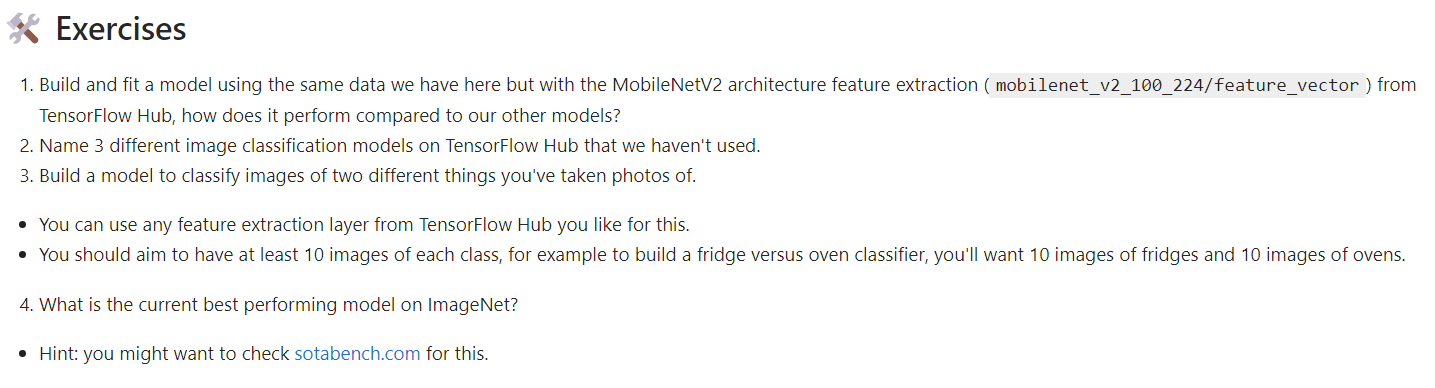

##1)Build and fit a model using the same data we have here but with the MobileNetV2 architecture feature extraction (mobilenet_v2_100_224/feature_vector) from TensorFlow Hub, how does it perform compared to our other models?

In [ ]:
!nvidia-smi

Wed Nov  2 11:19:46 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip', 'r')
zip_ref.extractall()
zip_ref.close()

--2022-11-02 11:19:48--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   280MB/s    in 0.6s    

2022-11-02 11:19:49 (280 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
  print(f'There are {len(dirnames)} directories and {len(filenames)} images')

There are 2 directories and 0 images
There are 10 directories and 0 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 0 directories and 75 images
There are 10 directories and 0 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images
There are 0 directories and 250 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')


print('Testing images:')
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                          target_size = IMAGE_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/'  + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir = log_dir
  )
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorboard_callback

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'

In [ ]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = 'feature_extractor_layer',
                                           input_shape = IMAGE_SHAPE+(3,))
  
  model = tf.keras.Sequential([
      feature_extractor_layer,
      tf.keras.layers.Dense(num_classes, activation = 'softmax', name = 'output1')
  ])
  return model

In [ ]:
mobilenet_model = create_model(mobilenet_url, num_classes = train_data_10_percent.num_classes)

mobilenet_model.compile(loss = 'categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

In [ ]:
mobilenet_history = mobilenet_model.fit(train_data_10_percent,
                                        epochs=10,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data_10_percent,
                                        validation_steps = len(test_data_10_percent),
                                        callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                 experiment_name = 'mobilenet_v2_100_224')])

Saving TensorBoard log files to tensorflow_hub/mobilenet_v2_100_224/20221102-112032
Epoch 1/10
24/24 [==============================] - 21s 660ms/step - loss: 1.9474 - accuracy: 0.3587 - val_loss: 1.2927 - val_accuracy: 0.6052
Epoch 2/10
24/24 [==============================] - 15s 635ms/step - loss: 1.0185 - accuracy: 0.7160 - val_loss: 0.8977 - val_accuracy: 0.7428
Epoch 3/10
24/24 [==============================] - 15s 664ms/step - loss: 0.7241 - accuracy: 0.7947 - val_loss: 0.7518 - val_accuracy: 0.7856
Epoch 4/10
24/24 [==============================] - 15s 635ms/step - loss: 0.5746 - accuracy: 0.8560 - val_loss: 0.6799 - val_accuracy: 0.7984
Epoch 5/10
24/24 [==============================] - 14s 622ms/step - loss: 0.4724 - accuracy: 0.8813 - val_loss: 0.6451 - val_accuracy: 0.8068
Epoch 6/10
24/24 [==============================] - 15s 664ms/step - loss: 0.3980 - accuracy: 0.9120 - val_loss: 0.6156 - val_accuracy: 0.8132
Epoch 7/10
24/24 [==============================] - 14s 62

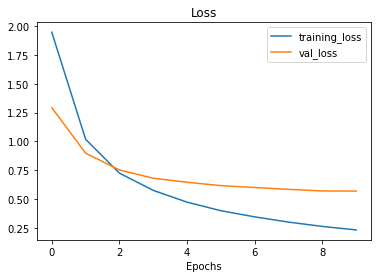

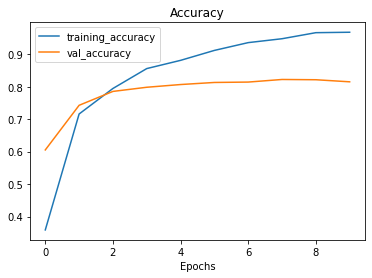

In [ ]:
plot_loss_curves(mobilenet_history)

In [ ]:
efficientnet_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [ ]:
efficientnet_model = create_model(efficientnet_url, num_classes = train_data_10_percent.num_classes)

efficientnet_model.compile(loss = 'categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

In [ ]:
efficientnet_history =efficientnet_model.fit(train_data_10_percent,
                                        epochs=10,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data_10_percent,
                                        validation_steps = len(test_data_10_percent),
                                        callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                 experiment_name = 'efficientnet')])

Saving TensorBoard log files to tensorflow_hub/efficientnet/20221102-114348
Epoch 1/10
24/24 [==============================] - 25s 735ms/step - loss: 1.8469 - accuracy: 0.4293 - val_loss: 1.3202 - val_accuracy: 0.7172
Epoch 2/10
24/24 [==============================] - 24s 1s/step - loss: 1.0634 - accuracy: 0.7693 - val_loss: 0.8768 - val_accuracy: 0.8124
Epoch 3/10
24/24 [==============================] - 16s 694ms/step - loss: 0.7588 - accuracy: 0.8360 - val_loss: 0.7038 - val_accuracy: 0.8392
Epoch 4/10
24/24 [==============================] - 16s 705ms/step - loss: 0.6088 - accuracy: 0.8693 - val_loss: 0.6160 - val_accuracy: 0.8544
Epoch 5/10
24/24 [==============================] - 16s 698ms/step - loss: 0.5131 - accuracy: 0.8867 - val_loss: 0.5592 - val_accuracy: 0.8628
Epoch 6/10
24/24 [==============================] - 18s 758ms/step - loss: 0.4458 - accuracy: 0.9053 - val_loss: 0.5213 - val_accuracy: 0.8688
Epoch 7/10
24/24 [==============================] - 16s 692ms/step - 

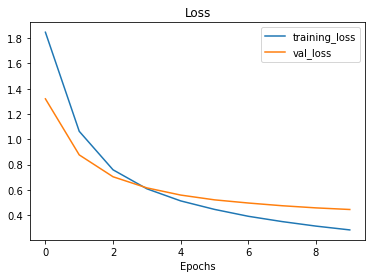

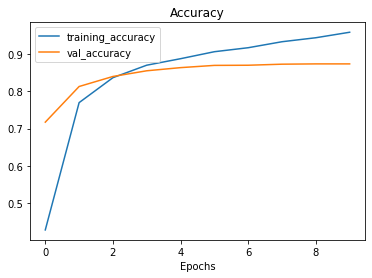

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
resnet_model = create_model(resnet_url, num_classes = train_data_10_percent.num_classes)

resnet_model.compile(loss = 'categorical_crossentropy',
                        optimizer = tf.keras.optimizers.Adam(),
                        metrics = ['accuracy'])

resnet_history =resnet_model.fit(train_data_10_percent,
                                        epochs=10,
                                        steps_per_epoch = len(train_data_10_percent),
                                        validation_data = test_data_10_percent,
                                        validation_steps = len(test_data_10_percent),
                                        callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                                 experiment_name = 'resnet')])

Saving TensorBoard log files to tensorflow_hub/resnet/20221102-114725
Epoch 1/10
24/24 [==============================] - 30s 1s/step - loss: 1.9090 - accuracy: 0.3720 - val_loss: 1.1614 - val_accuracy: 0.6388
Epoch 2/10
24/24 [==============================] - 22s 952ms/step - loss: 0.8855 - accuracy: 0.7387 - val_loss: 0.8308 - val_accuracy: 0.7264
Epoch 3/10
24/24 [==============================] - 25s 1s/step - loss: 0.6114 - accuracy: 0.8200 - val_loss: 0.7498 - val_accuracy: 0.7556
Epoch 4/10
24/24 [==============================] - 20s 863ms/step - loss: 0.4668 - accuracy: 0.8800 - val_loss: 0.7063 - val_accuracy: 0.7668
Epoch 5/10
24/24 [==============================] - 25s 1s/step - loss: 0.3770 - accuracy: 0.9107 - val_loss: 0.6779 - val_accuracy: 0.7796
Epoch 6/10
24/24 [==============================] - 20s 856ms/step - loss: 0.3065 - accuracy: 0.9413 - val_loss: 0.6432 - val_accuracy: 0.7856
Epoch 7/10
24/24 [==============================] - 17s 740ms/step - loss: 0.2591

In [ ]:
plot_loss_curves(resnet_history)

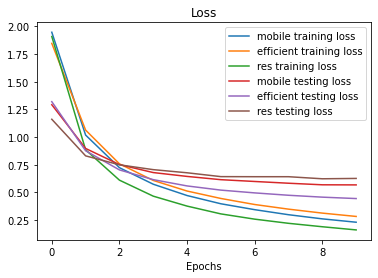

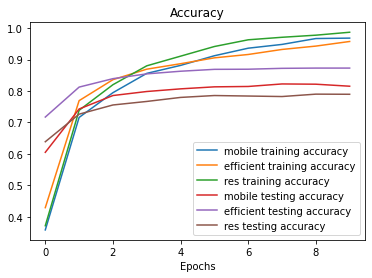

In [ ]:
mobilenet_loss = mobilenet_history.history['loss']
efficientnet_loss = efficientnet_history.history['loss']
resnet_loss = resnet_history.history['loss']
mobilenet_val_loss = mobilenet_history.history['val_loss']
efficientnet_val_loss = efficientnet_history.history['val_loss']
resnet_val_loss = resnet_history.history['val_loss']

mobilenet_accuracy = mobilenet_history.history['accuracy']
efficientnet_accuracy = efficientnet_history.history['accuracy']
resnet_accuracy = resnet_history.history['accuracy']
mobilenet_val_accuracy = mobilenet_history.history['val_accuracy']
efficientnet_val_accuracy = efficientnet_history.history['val_accuracy']
resnet_val_accuracy = resnet_history.history['val_accuracy']

epochs = range(len(mobilenet_history.history['loss']))

#plotloss
plt.plot(epochs, mobilenet_loss, label = 'mobile training loss')
plt.plot(epochs, efficientnet_loss, label = 'efficient training loss')
plt.plot(epochs, resnet_loss, label = 'res training loss')

plt.plot(epochs, mobilenet_val_loss, label = 'mobile testing loss')
plt.plot(epochs, efficientnet_val_loss, label = 'efficient testing loss')
plt.plot(epochs, resnet_val_loss, label = 'res testing loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

#plot accuracy
plt.figure()
plt.plot(epochs, mobilenet_accuracy, label = 'mobile training accuracy')
plt.plot(epochs, efficientnet_accuracy, label = 'efficient training accuracy')
plt.plot(epochs, resnet_accuracy, label = 'res training accuracy')

plt.plot(epochs, mobilenet_val_accuracy, label = 'mobile testing accuracy')
plt.plot(epochs, efficientnet_val_accuracy, label = 'efficient testing accuracy')
plt.plot(epochs, resnet_val_accuracy, label = 'res testing accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend()


In [ ]:
!tensorboard dev list


https://tensorboard.dev/experiment/7e7mF6bSR0O6e9tEXVrbug/
	Name                 MobileNetV2_100
	Description          idk
	Id                   7e7mF6bSR0O6e9tEXVrbug
	Created              2022-11-02 11:16:43 (38 minutes ago)
	Updated              2022-11-02 11:16:45 (38 minutes ago)
	Runs                 2
	Tags                 5
	Scalars              30
	Tensor bytes         0
	Binary object bytes  1634821
Total: 1 experiment(s)


In [ ]:
!tensorboard dev delete --experiment_id 7e7mF6bSR0O6e9tEXVrbug
!tensorboard dev list

Deleted experiment 7e7mF6bSR0O6e9tEXVrbug.
No experiments. Use `tensorboard dev upload` to get started.


In [ ]:
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "MobileNetV2 vsEfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/AcZcmEgGS7O05zUoCyf0pQ/

[2022-11-02T11:56:46] Started scanning logdir.
[2022-11-02T11:56:57] Total uploaded: 330 scalars, 0 tensors, 6 binary objects (14.4 MB)
[2022-11-02T11:56:57] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/AcZcmEgGS7O05zUoCyf0pQ/


##2) Name 3 different image classification models on TensorFlow Hub that we haven't used.



Inception V2, v3.
Inception ResNet,
ConvNeXt,


##3) Build a model to classify images of two different things you've taken photos of.

Proyect dog breeds classificator in https://github.com/Rubnserrano/KAGGLE_-projects/dog_breeds_classifier.ipynb

#4)What is the current best performing model on ImageNet?

CoCa


https://paperswithcode.com/sota/image-classification-on-imagenet